In [2]:
import pandas as pd
import numpy as np
import openai
import nltk
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/benmischeck/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
api_key = "XXXX"
client = openai.OpenAI(api_key=api_key)

In [ ]:
# Import the survey ideas from the pre-cleaned vesion
df_ideas = pd.read_excel("XXXX/SurveyResults_clean.xlsx")

# Select the needed columns
df_ideas = df_ideas[['Response ID','GroupAssignment', 'idea_elaboration']]

# Display the survey ideas
display(df_ideas)

,Response ID,GroupAssignment,idea_elaboration
0,R_2MeVhGrthluSOHf,Human_Human,A Smart outlet helps save electricity by autom...
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,Shoes made of ocean plastic would reduce the w...
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,Reusable water bottles can be a key component ...
3,R_8X68xD9TOB81k0E,Human_Human/AI,Core Concept: reuseable bags to minimize envir...
4,R_8dj9aA2If4L0AXS,Human/AI_Human,Community Solar sharing is a decentralized ene...
...,...,...,...
95,R_2VjYLyvWLK2W2c0,Human_Human/AI,Recycling home kits are innovative products th...
96,R_2hXSc7JOdfYXCbF,Human/AI_Human,Wearable air quality monitors can be detached ...
97,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,Plant-based meal kit delivery offers a conveni...
98,R_88GoPhwGUi5v6yC,Human_Human,Packaging boxes can often be used several time...


In [5]:
# Create function to create vectors using OpenAI embedding model
def get_openai_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding 

# Create function to calculate the cohesion score of various sentences
def cohesion_score(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return 1.0  
    embeddings = np.array([get_openai_embedding(sent) for sent in sentences])
    similarity_matrix = cosine_similarity(embeddings)
    n = len(sentences)
    # Calculate the cohesion of the description using the average
    cohesion = (np.sum(similarity_matrix) - n) / (n * (n - 1)) 
    return cohesion

In [6]:
# Calculate cohesion score for each idea elaboration
df_ideas["idea_cohesion"] = df_ideas["idea_elaboration"].apply(cohesion_score)
display(df_ideas)

,Response ID,GroupAssignment,idea_elaboration,idea_cohesion
0,R_2MeVhGrthluSOHf,Human_Human,A Smart outlet helps save electricity by autom...,0.396114
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,Shoes made of ocean plastic would reduce the w...,0.524744
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,Reusable water bottles can be a key component ...,0.494533
3,R_8X68xD9TOB81k0E,Human_Human/AI,Core Concept: reuseable bags to minimize envir...,1.000000
4,R_8dj9aA2If4L0AXS,Human/AI_Human,Community Solar sharing is a decentralized ene...,0.409679
...,...,...,...,...
95,R_2VjYLyvWLK2W2c0,Human_Human/AI,Recycling home kits are innovative products th...,0.655237
96,R_2hXSc7JOdfYXCbF,Human/AI_Human,Wearable air quality monitors can be detached ...,0.394505
97,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,Plant-based meal kit delivery offers a conveni...,0.531682
98,R_88GoPhwGUi5v6yC,Human_Human,Packaging boxes can often be used several time...,0.589545


In [ ]:
# Import the scraped data
sharktank_products = pd.read_csv("XXXX/sharktanklab_data.csv")
sharktank_desc = pd.read_excel("XXXX/sharktank_products.xlsx")

# Clean the product names to merge them
sharktank_products['Product'] = sharktank_products['Product'].str.strip().str.lower().str.replace(r'\s+', '', regex=True).str.replace(r"[^\w]", "", regex=True)
sharktank_products['Category'] = sharktank_products['Category'].apply(lambda x: x.split(';')[0].strip() if isinstance(x, str) else x)
sharktank_desc['Product Title'] = sharktank_desc['Product Title'].str.strip().str.lower().str.replace(r'\s+', '', regex=True).str.replace(r"[^\w]", "", regex=True)
sharktank_desc['Short Description'] = sharktank_desc['Short Description'].str.replace(r"PRODUCT SUMMARY", "", regex=True)

# Merge the data frames on 'Product' or 'Product Title' 
df_sharktank = pd.merge(sharktank_products, sharktank_desc, left_on='Product', right_on='Product Title', how='inner')

# Create new dataframe with necessary columns
df_sharktank = df_sharktank[['Product', 'Category', 'Short Description', 'Long Description', 'Deal Y/N', 'Invested Amount', '% Equity (Deal)']]
df_sharktank = df_sharktank.dropna()

# Rename the columns as needed 
df_sharktank.rename(columns={
    'Product': 'product name',
    'Category': 'industry',
    'Short Description': 'short_description',
    'Long Description': 'long_description', 
    'Deal Y/N' : 'deal_Y/N',
    'Invested Amount': 'invested_amount',
    '% Equity (Deal)': 'percentag_equity'
}, inplace=True)

# Add new column to calculate the idea/company value based on invested amount and equity
df_sharktank['invested_amount_clean'] = df_sharktank['invested_amount'].replace('[\$,]', '', regex=True).replace('—', np.nan).astype(float)
df_sharktank['percentag_equity_clean'] = df_sharktank['percentag_equity'].replace('%', '', regex=True).replace('—', np.nan).astype(float)
df_sharktank['product_value'] = df_sharktank['invested_amount_clean'] / (df_sharktank['percentag_equity_clean'] / 100)

# Display the new dataframe
print(df_sharktank['industry'].value_counts())
display(df_sharktank)


industry
Home & Tools               248
Food & Drink               218
Clothing & Accessories     185
Beauty & Health            121
Kids & Toys                112
Sports & Outdoors           83
Entertainment & Arts        62
Service                     59
Tech & Electronics          43
Apps                        42
Pet Care                    42
Automotive & Industrial     18
Name: count, dtype: int64


,product name,industry,short_description,long_description,deal_Y/N,invested_amount,percentag_equity,invested_amount_clean,percentag_equity_clean,product_value
0,wildwonderprobioticdrinks,Food & Drink,wildwonder is a sparkling drink that reimagine...,wildwonder offers a unique beverage that prior...,Deal,"$500,000",6.0%,500000.0,6.0,8.333333e+06
1,youthforiasustainablemakeup,Beauty & Health,"Youthforia offers bio-based makeup products, i...",Youthforia’s flagship product is the BYO Blush...,Deal,"$400,000",8.0%,400000.0,8.0,5.000000e+06
2,noshifoodpaintforkids,Food & Drink,"Noshi offers edible, organic Food Paint and co...","Noshi offers edible, organic Food Paint and co...",Deal,"$250,000",25.0%,250000.0,25.0,1.000000e+06
3,ghianonalcoholicaperitif,Food & Drink,Ghia is a nonalcoholic beverage that offers a ...,"Ghia is an all-natural, non-alcoholic aperitif...",No Deal,—,—,NaN,NaN,NaN
4,frshcarairfreshener,Automotive & Industrial,Ride FRSH is a subscription-based car air fres...,Ride FRSH offers a subscription-based service ...,Deal,"$200,000",20.0%,200000.0,20.0,1.000000e+06
...,...,...,...,...,...,...,...,...,...,...
1252,turbobaster,Home & Tools,The TurboBaster is a battery-operated basting ...,The TurboBaster is a groundbreaking kitchen to...,Deal,"$35,000",100.0%,35000.0,100.0,3.500000e+04
1253,thebobbleplacebobbleheads,Entertainment & Arts,Bobble Place creates custom bobblehead dolls b...,Bobble Place offers custom bobblehead dolls th...,No Deal,—,—,NaN,NaN,NaN
1254,faceblok,Clothing & Accessories,Face-Block offers a collection of fashion surg...,Face-Block offers a unique twist on traditiona...,No Deal,—,—,NaN,NaN,NaN
1255,weecanshop,Kids & Toys,Wee Can Shop is a whimsical gift shop where ch...,Wee Can Shop offers a unique and enchanting sh...,No Deal,—,—,NaN,NaN,NaN


In [8]:
# Compute embeddings for shark tank products 'long_description'
df_sharktank["embedding"] = df_sharktank["long_description"].apply(get_openai_embedding)
sharktank_embeddings = np.array(df_sharktank["embedding"].tolist())

# Compute embeddings for survey ideas 'idea_elaboration'
df_ideas["embedding"] = df_ideas["idea_elaboration"].apply(get_openai_embedding)
idea_embeddings = np.array(df_ideas["embedding"].tolist())

# Calculat the cosine similarity between embeddings
similarity_matrix = cosine_similarity(idea_embeddings, sharktank_embeddings)

# Find the most similar sharktank product ('long_description') for each survey idea ('idea_elaboration')
df_ideas["most_similar_sharktank_product_list"] = np.argmax(similarity_matrix, axis=1)
df_ideas["most_similar_sharktank_product"] = df_ideas["most_similar_sharktank_product_list"].apply(lambda i: df_sharktank.iloc[i]["long_description"])
df_ideas["cosine_similarity"] = np.max(similarity_matrix, axis=1)

In [ ]:
# Add the relevant deal information to the new dataframe
df_ideas_evaluation = df_ideas[["Response ID", "GroupAssignment", "idea_cohesion", "idea_elaboration", "most_similar_sharktank_product", "cosine_similarity"]]
df_sharktank_filtered = df_sharktank[['long_description', 'deal_Y/N', 'invested_amount', 'percentag_equity', 'product_value']]
df_ideas_evaluation = pd.merge(df_ideas_evaluation, df_sharktank_filtered, left_on='most_similar_sharktank_product', right_on='long_description', how='left')
df_ideas_evaluation.to_excel("XXXX/df_ideas_usefulness_metrics.xlsx", index=False)
display(df_ideas_evaluation)

,Response ID,GroupAssignment,idea_cohesion,idea_elaboration,most_similar_sharktank_product,cosine_similarity,long_description,deal_Y/N,invested_amount,percentag_equity,product_value
0,R_2MeVhGrthluSOHf,Human_Human,0.396114,A Smart outlet helps save electricity by autom...,InvisiPlug revolutionizes the way surge protec...,0.432565,InvisiPlug revolutionizes the way surge protec...,Deal,"$125,000",10.0%,1.250000e+06
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,0.524744,Shoes made of ocean plastic would reduce the w...,Remyxx sneakers are not just stylish footwear ...,0.453860,Remyxx sneakers are not just stylish footwear ...,Deal,"$50,000",80.0%,6.250000e+04
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,0.494533,Reusable water bottles can be a key component ...,Clean Bottle is a uniquely designed water bott...,0.552051,Clean Bottle is a uniquely designed water bott...,Deal,"$60,000",8.0%,7.500000e+05
3,R_8X68xD9TOB81k0E,Human_Human/AI,1.000000,Core Concept: reuseable bags to minimize envir...,Rareform’s innovative product line revolves ar...,0.516364,Rareform’s innovative product line revolves ar...,Deal,"$300,000",10.0%,3.000000e+06
4,R_8dj9aA2If4L0AXS,Human/AI_Human,0.409679,Community Solar sharing is a decentralized ene...,CAB20 offers investors a stake in their revenu...,0.381378,CAB20 offers investors a stake in their revenu...,No Deal,—,—,NaN
...,...,...,...,...,...,...,...,...,...,...,...
97,R_2VjYLyvWLK2W2c0,Human_Human/AI,0.655237,Recycling home kits are innovative products th...,Retold Recycling provides a simple and efficie...,0.555248,Retold Recycling provides a simple and efficie...,Deal,"$300,000",25.0%,1.200000e+06
98,R_2hXSc7JOdfYXCbF,Human/AI_Human,0.394505,Wearable air quality monitors can be detached ...,Breathometer offers a groundbreaking solution ...,0.479926,Breathometer offers a groundbreaking solution ...,Deal,"$1,000,000",30.0%,3.333333e+06
99,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,0.531682,Plant-based meal kit delivery offers a conveni...,Plated offers a convenient solution for busy i...,0.543750,Plated offers a convenient solution for busy i...,Deal,"$500,000",5.5%,9.090909e+06
100,R_88GoPhwGUi5v6yC,Human_Human,0.589545,Packaging boxes can often be used several time...,"GreenBox, the innovative pizza box presented o...",0.501511,"GreenBox, the innovative pizza box presented o...",Deal,"$300,000",10.0%,3.000000e+06


In [10]:
# Filter for the minimum similarity threshold (>0.50)
deal_info = df_ideas_evaluation[df_ideas_evaluation['cosine_similarity']>0.50]
deal_info = deal_info.groupby('GroupAssignment')['deal_Y/N'].value_counts()

print("Positive predicited deals:", deal_info)

Positive predicited deals: GroupAssignment    deal_Y/N
Human/AI_Human     Deal        5
Human/AI_Human/AI  Deal        6
                   No Deal     1
Human_Human        Deal        5
                   No Deal     2
Human_Human/AI     No Deal     8
                   Deal        7
Name: count, dtype: int64


In [ ]:
# Import chatgpt survey responses
df_chatgpt = pd.read_csv("XXX/chatgpt_survey_responses.csv")

# Compute embeddings for survey ideas 'idea_elaboration'
df_chatgpt["embedding"] = df_chatgpt["Task2"].apply(get_openai_embedding)
idea_embeddings = np.array(df_chatgpt["embedding"].tolist())

# Calculat the cosine similarity between embeddings
similarity_matrix = cosine_similarity(idea_embeddings, sharktank_embeddings)

# Find the most similar sharktank product ('long_description') for each survey idea ('idea_elaboration')
df_chatgpt["most_similar_sharktank_product_list"] = np.argmax(similarity_matrix, axis=1)
df_chatgpt["most_similar_sharktank_product"] = df_chatgpt["most_similar_sharktank_product_list"].apply(lambda i: df_sharktank.iloc[i]["long_description"])
df_chatgpt["cosine_similarity"] = np.max(similarity_matrix, axis=1)

In [ ]:
df_chatgpt_deal = pd.merge(df_chatgpt, df_sharktank_filtered, left_on='most_similar_sharktank_product', right_on='long_description', how='left')

deal_info = df_chatgpt_deal['deal_Y/N'].value_counts()

print(deal_info)

deal_Y/N
Deal       41
No Deal    11
Name: count, dtype: int64


In [ ]:
display(df_chatgpt_deal)
df_chatgpt_deal.to_excel("XXXX/df_chatgpt_usefulness_metrics.xlsx", index=False)

,Iteration,DAT,Task1,Task2,embedding,most_similar_sharktank_product_list,most_similar_sharktank_product,cosine_similarity,long_description,deal_Y/N,invested_amount,percentag_equity,product_value
0,1,"Elephant, cloud, guitar, lighthouse, cupcake, ...",Eco-Commuter App \nUrban Vertical Gardens \n...,"Sure, I'll refine the Eco-Commuter App. The co...","[0.021029021590948105, -0.0013314944226294756,...",832,"The Air Car, developed by Zero Pollution Motor...",0.469699,"The Air Car, developed by Zero Pollution Motor...",Deal,"$5,000,000",50.0%,1.000000e+07
1,2,"Whale, guitar, cactus, spoon, thunder, zebra, ...",Urban Vertical Farming Kits \nSolar-Powered C...,The Eco-Friendly Ride-Sharing App connects env...,"[-0.0015064658364281058, -0.05736448988318443,...",832,"The Air Car, developed by Zero Pollution Motor...",0.537425,"The Air Car, developed by Zero Pollution Motor...",Deal,"$5,000,000",50.0%,1.000000e+07
2,3,"Pillow, galaxy, violin, cactus, sandwich, bicy...",Smart Solar Windows \nCommunity Garden Networ...,Smart Solar Windows harness solar energy using...,"[-0.033985767513513565, 0.021731285378336906, ...",355,Grouphug’s window solar charger is a 10-watt p...,0.474118,Grouphug’s window solar charger is a 10-watt p...,Deal,"$150,000",25.0%,6.000000e+05
3,4,"Sandwich, galaxy, pencil, whisper, fog, dragon...",EcoSmart Home Hubs \nUrban Vertical Gardens ...,EcoSmart Home Hubs offer an all-in-one solutio...,"[0.01250527985394001, -0.027044331654906273, -...",795,"The Keen Vent, a groundbreaking product from K...",0.415387,"The Keen Vent, a groundbreaking product from K...",Deal,"$750,000",13.0%,5.769231e+06
4,5,"Spoon, lamp, galaxy, sandcastle, butterfly, um...",Urban Vertical Gardens \nEco-Friendly Commut...,"The ""AI-Driven Energy Optimizers"" concept focu...","[-0.004390164744108915, -0.00809512473642826, ...",324,"ABii, the smart robot tutor, engages students ...",0.415344,"ABii, the smart robot tutor, engages students ...",No Deal,—,—,NaN
5,6,"Book, lamp, kettle, sand, giraffe, cloud, bicy...",- Solar Window Panels \n- Smart Compost Bins ...,Urban Vertical Farms transform unused urban sp...,"[-0.04315042123198509, -0.005686609074473381, ...",1028,Urbio is a versatile vertical garden system th...,0.523492,Urbio is a versatile vertical garden system th...,Deal,"$300,000",15.0%,2.000000e+06
6,7,"Giraffe, Notebook, Volcano, Whisper, Pancake, ...",Urban Composting Kit \nRooftop Garden Modules...,The Urban Composting Kit is designed to turn c...,"[0.013288530521094799, -0.01390572264790535, -...",1028,Urbio is a versatile vertical garden system th...,0.511772,Urbio is a versatile vertical garden system th...,Deal,"$300,000",15.0%,2.000000e+06
7,8,"Chair, ocean, clock, zebra, sandwich, suitcase...",EcoSmart Home Kit \nUrban Community Garden Ne...,The GreenCommute App is designed to reduce urb...,"[0.02980165183544159, 0.0046630664728581905, 0...",832,"The Air Car, developed by Zero Pollution Motor...",0.475199,"The Air Car, developed by Zero Pollution Motor...",Deal,"$5,000,000",50.0%,1.000000e+07
8,9,"Cat, galaxy, mustard, violin, iceberg, hammock...",Urban Solar Charging Stations \nSmart Waste S...,Urban Solar Charging Stations offer clean ener...,"[-0.01639740541577339, -0.05228353291749954, 0...",832,"The Air Car, developed by Zero Pollution Motor...",0.457476,"The Air Car, developed by Zero Pollution Motor...",Deal,"$5,000,000",50.0%,1.000000e+07
9,10,"Elephant, cloud, guitar, pancake, volcano, mir...",Smart Energy Hub \nUrban Vertical Gardens \n...,The Smart Energy Hub is a dynamic system that ...,"[-0.025768375024199486, -0.017814554274082184,...",1082,The Heat Helper works by recycling heated air ...,0.442438,The Heat Helper works by recycling heated air ...,No Deal,—,—,NaN


In [65]:
# Format columns to match when merging
df_chatgpt_deal = df_chatgpt_deal[['deal_Y/N', 'cosine_similarity']]
df_chatgpt_deal['idea_source'] = "AI"
df_survey_deal = df_ideas_evaluation[['GroupAssignment', 'deal_Y/N', 'cosine_similarity']]
df_survey_deal['idea_source'] = df_survey_deal['GroupAssignment'].apply(lambda x: "Human" if x in ['Human_Human', 'Human/AI_Human'] else "HumanAI" )
df_survey_deal = df_survey_deal[['deal_Y/N', 'idea_source', 'cosine_similarity']]
df_deal = pd.concat([df_survey_deal, df_chatgpt_deal], ignore_index=True)
df_deal.loc[df_deal['cosine_similarity'] < 0.5, 'deal_Y/N'] = 'No Deal'

# Define a contigency table to check distribution
contingency = pd.crosstab(df_deal['idea_source'], df_deal['deal_Y/N'])
print("Contingency Table:")
print(contingency)

# Run  chi-squared test
chi2, pval, dof, expected = stats.chi2_contingency(contingency)

print(f"\nChi-squared statistic: {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {pval:.4f}")


Contingency Table:
deal_Y/N     Deal  No Deal
idea_source               
AI             22       30
Human          10       45
HumanAI        13       34

Chi-squared statistic: 7.602
Degrees of freedom: 2
P-value: 0.0223


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_21220/25071068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_deal['idea_source'] = df_survey_deal['GroupAssignment'].apply(lambda x: "Human" if x in ['Human_Human', 'Human/AI_Human'] else "HumanAI" )


In [66]:
# Prepare dataset to be used as training dataset for classificaiton model
# Drop N/A in shark tank data + create deal label
df_sharktank = df_sharktank.dropna(subset=["long_description", "deal_Y/N"])
df_sharktank['deal_label'] = df_sharktank['deal_Y/N'].map({"Deal": 1, "No Deal": 0})

# compute emebedding for 'long_description'
shark_embeddings = df_sharktank['long_description'].apply(lambda x: get_openai_embedding(x))
X = np.vstack(shark_embeddings.values)
y = df_sharktank['deal_label'].values

# Step 3: Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Logsitic Regression:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Logsitic Regression:
[[ 23  63]
 [ 35 126]]
              precision    recall  f1-score   support

           0      0.397     0.267     0.319        86
           1      0.667     0.783     0.720       161

    accuracy                          0.603       247
   macro avg      0.532     0.525     0.520       247
weighted avg      0.573     0.603     0.581       247



In [68]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

Random Forest:
[[ 12  74]
 [ 12 149]]
              precision    recall  f1-score   support

           0      0.500     0.140     0.218        86
           1      0.668     0.925     0.776       161

    accuracy                          0.652       247
   macro avg      0.584     0.533     0.497       247
weighted avg      0.610     0.652     0.582       247



In [69]:
# Support Vector Machine
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svm_clf = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)

y_pred_svm = svm_clf.predict(X_test_scaled)
print("Support Vector Machine:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=3))


Support Vector Machine:
[[39 47]
 [63 98]]
              precision    recall  f1-score   support

           0      0.382     0.453     0.415        86
           1      0.676     0.609     0.641       161

    accuracy                          0.555       247
   macro avg      0.529     0.531     0.528       247
weighted avg      0.574     0.555     0.562       247



In [71]:
# Configure the final classification model using XGBoost
import openai
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Define OpenAI enviroment + embedding function
client = openai.OpenAI(api_key=api_key)
def get_openai_embeddings(texts):
    response = client.embeddings.create(
        input=texts,
        model="text-embedding-3-large"
    )
    return np.array([res.embedding for res in response.data], dtype=np.float32)

# generate embeddings 
descriptions = df_sharktank['long_description'].tolist()
X = get_openai_embeddings(descriptions)
y = df_sharktank['deal_label'].values

# resample training 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# split the data into test and trainig set
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# use class weights for balanced training
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# configure model 
model_xgb = keras.Sequential([
    layers.Dense(384, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(192, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

# compile model
optimizer = Adam(learning_rate=0.0001)
model_xgb.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# train the model
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_xgb.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# evaluate the model
loss, accuracy = model_xgb.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred = model_xgb.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))


/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4696 - loss: 1.6919 - val_accuracy: 0.5473 - val_loss: 1.5740
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5584 - loss: 1.5367 - val_accuracy: 0.5709 - val_loss: 1.4417
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5933 - loss: 1.4039 - val_accuracy: 0.5912 - val_loss: 1.3313
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6752 - loss: 1.2927 - val_accuracy: 0.6081 - val_loss: 1.2401
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6534 - loss: 1.2030 - val_accuracy: 0.6149 - val_loss: 1.1657
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7019 - loss: 1.1133 - val_accuracy: 0.5845 - val_loss: 1.1095
Epoch 7/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7090 - loss: 1.0423 - val_accuracy: 0.6149 - val_loss: 1.0568
Epoch 8/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7203 - loss: 0.9870 - val_accuracy: 0.6081 - v

In [102]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       148
           1       0.64      0.60      0.62       148

    accuracy                           0.64       296
   macro avg       0.64      0.64      0.63       296
weighted avg       0.64      0.64      0.63       296



In [72]:
# define function to predict deal probability
def predict_row(row, model):
    embedding = get_openai_embeddings([row["idea_elaboration"]])[0].reshape(1, -1)
    prob = model.predict(embedding)[0][0]
    prediction = int(prob > 0.5)
    return pd.Series({"deal_probability": prob, "deal_prediction": prediction})

# apply to participant-generated ideas
df_ideas[["deal_probability", "deal_prediction"]] = df_ideas.apply(
    lambda row: predict_row(row, model=model_xgb), axis=1
)

display(df_ideas)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

,Response ID,GroupAssignment,idea_elaboration,idea_cohesion,embedding,most_similar_sharktank_product_list,most_similar_sharktank_product,cosine_similarity,deal_probability,deal_prediction
0,R_2MeVhGrthluSOHf,Human_Human,A Smart outlet helps save electricity by autom...,0.396106,"[0.01709856651723385, 0.007952266372740269, -0...",970,InvisiPlug revolutionizes the way surge protec...,0.432590,0.725807,1.0
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,Shoes made of ocean plastic would reduce the w...,0.524772,"[0.04340202733874321, 0.025371037423610687, 0....",1136,Remyxx sneakers are not just stylish footwear ...,0.453898,0.227760,0.0
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,Reusable water bottles can be a key component ...,0.494548,"[0.05356146767735481, 0.020408354699611664, 0....",1127,Clean Bottle is a uniquely designed water bott...,0.552443,0.745676,1.0
3,R_8X68xD9TOB81k0E,Human_Human/AI,Core Concept: reuseable bags to minimize envir...,1.000000,"[0.06182096153497696, 0.020286625251173973, 0....",566,Rareform’s innovative product line revolves ar...,0.516364,0.279115,0.0
4,R_8dj9aA2If4L0AXS,Human/AI_Human,Community Solar sharing is a decentralized ene...,0.409663,"[0.015225007198750973, -0.034211184829473495, ...",1112,CAB20 offers investors a stake in their revenu...,0.381382,0.419057,0.0
...,...,...,...,...,...,...,...,...,...,...
95,R_2VjYLyvWLK2W2c0,Human_Human/AI,Recycling home kits are innovative products th...,0.655203,"[0.03646974638104439, 0.003238053061068058, 0....",16,Retold Recycling provides a simple and efficie...,0.555248,0.730159,1.0
96,R_2hXSc7JOdfYXCbF,Human/AI_Human,Wearable air quality monitors can be detached ...,0.394546,"[0.055311478674411774, 0.04174831882119179, -0...",897,Breathometer offers a groundbreaking solution ...,0.479926,0.664525,1.0
97,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,Plant-based meal kit delivery offers a conveni...,0.531700,"[-0.0242417324334383, -0.031410492956638336, 0...",958,Plated offers a convenient solution for busy i...,0.543750,0.521675,1.0
98,R_88GoPhwGUi5v6yC,Human_Human,Packaging boxes can often be used several time...,0.589494,"[0.036523107439279556, 0.01019714493304491, 0....",840,"GreenBox, the innovative pizza box presented o...",0.501517,0.825378,1.0


In [ ]:
# import additional data about participants
df_participants = pd.read_excel("XXXX/SurveyResults_clean.xlsx")
columns = ['Response ID', 'Task2_ChatGPT_Access', 'Task2_ChatGPT_Interaction', 'DAT_score', 'BusinessFamilarity', 'EngExp', 'ProfField', 'InnoMgmtExp', 'SustainabilityExp', 'GenAIExp', 'GenAIFrequency', 'Age', 'Gender']
df_participants = df_participants[columns]

df_ideas = pd.merge(df_ideas, df_participants, left_on='Response ID', right_on='Response ID', how='left')

In [74]:
# dummy encoding of all relevant control variables
df_ideas['BusinessFamiliarity_High'] = df_ideas['BusinessFamilarity'].apply(lambda x: 1 if x in ['Very familiar', 'Extremely familiar'] else 0)
df_ideas['EngExp_High'] = df_ideas['EngExp'].apply(lambda x: 1 if x in ['Near-Native (C2)', 'Native'] else 0)
df_ideas['ProfField_Business'] = df_ideas['ProfField'].apply(lambda x: 1 if x in ['Business, Economics, & Management'] else 0)
df_ideas['InnoMgmtExp_High'] = df_ideas['InnoMgmtExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['SustainabilityExp_High'] = df_ideas['SustainabilityExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['GenAIExp_High'] = df_ideas['GenAIExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['GenAIFrequency_High'] = df_ideas['GenAIFrequency'].apply(lambda x: 1 if x in ['Daily or almost daily', 'Frequently (1-3x per week)'] else 0)
df_ideas['Age_35+'] = df_ideas['Age'].apply(lambda x: 1 if x in ['35–44', '45-54', '55-64', '65 or older'] else 0)
df_ideas['Gender_Male'] = df_ideas['Gender'].apply(lambda x: 1 if x in ['Male'] else 0)

# standardize DAT score using z score
scaler = StandardScaler()
df_ideas['DAT_score_standardized'] = scaler.fit_transform(df_ideas[['DAT_score']])

display(df_ideas)

,Response ID,GroupAssignment,idea_elaboration,idea_cohesion,embedding,most_similar_sharktank_product_list,most_similar_sharktank_product,cosine_similarity,deal_probability,deal_prediction,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_2MeVhGrthluSOHf,Human_Human,A Smart outlet helps save electricity by autom...,0.396106,"[0.01709856651723385, 0.007952266372740269, -0...",970,InvisiPlug revolutionizes the way surge protec...,0.432590,0.725807,1.0,...,0,0,1,0,0,0,1,0,0,0.049322
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,Shoes made of ocean plastic would reduce the w...,0.524772,"[0.04340202733874321, 0.025371037423610687, 0....",1136,Remyxx sneakers are not just stylish footwear ...,0.453898,0.227760,0.0,...,1,0,1,0,0,1,1,0,0,-0.290886
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,Reusable water bottles can be a key component ...,0.494548,"[0.05356146767735481, 0.020408354699611664, 0....",1127,Clean Bottle is a uniquely designed water bott...,0.552443,0.745676,1.0,...,0,0,1,0,1,1,1,0,1,-0.048407
3,R_8X68xD9TOB81k0E,Human_Human/AI,Core Concept: reuseable bags to minimize envir...,1.000000,"[0.06182096153497696, 0.020286625251173973, 0....",566,Rareform’s innovative product line revolves ar...,0.516364,0.279115,0.0,...,1,0,1,1,0,1,1,0,0,0.504692
4,R_8dj9aA2If4L0AXS,Human/AI_Human,Community Solar sharing is a decentralized ene...,0.409663,"[0.015225007198750973, -0.034211184829473495, ...",1112,CAB20 offers investors a stake in their revenu...,0.381382,0.419057,0.0,...,0,0,1,0,1,1,1,0,1,1.108534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,R_2VjYLyvWLK2W2c0,Human_Human/AI,Recycling home kits are innovative products th...,0.655203,"[0.03646974638104439, 0.003238053061068058, 0....",16,Retold Recycling provides a simple and efficie...,0.555248,0.730159,1.0,...,0,0,1,0,0,1,1,0,0,-0.574222
96,R_2hXSc7JOdfYXCbF,Human/AI_Human,Wearable air quality monitors can be detached ...,0.394546,"[0.055311478674411774, 0.04174831882119179, -0...",897,Breathometer offers a groundbreaking solution ...,0.479926,0.664525,1.0,...,0,0,1,0,0,1,1,0,1,-0.801314
97,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,Plant-based meal kit delivery offers a conveni...,0.531700,"[-0.0242417324334383, -0.031410492956638336, 0...",958,Plated offers a convenient solution for busy i...,0.543750,0.521675,1.0,...,1,1,1,0,1,1,1,0,0,-0.360011
98,R_88GoPhwGUi5v6yC,Human_Human,Packaging boxes can often be used several time...,0.589494,"[0.036523107439279556, 0.01019714493304491, 0....",840,"GreenBox, the innovative pizza box presented o...",0.501517,0.825378,1.0,...,1,1,0,0,1,1,1,0,1,0.634186


Correlation between ChatGPT access (Task 2) and idea cohesion: 0.153
                            OLS Regression Results                            
Dep. Variable:       deal_probability   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.340
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.129
Time:                        09:28:30   Log-Likelihood:                 16.769
No. Observations:                 100   AIC:                            -29.54
Df Residuals:                      98   BIC:                            -24.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

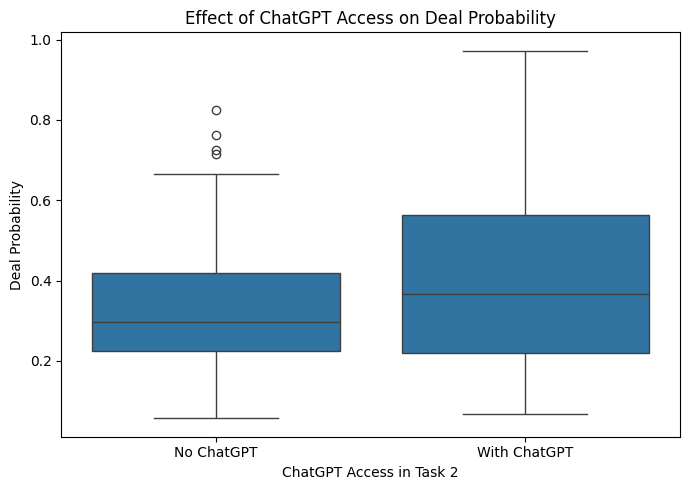

In [75]:
# compute correlation of deal_probablity and chatgpt access in task 2
correlation = df_ideas["deal_probability"].corr(df_ideas["Task2_ChatGPT_Access"])
print(f"Correlation between ChatGPT access (Task 2) and idea cohesion: {correlation:.3f}")

# build OLS model
X = df_ideas["Task2_ChatGPT_Access"]  
X = sm.add_constant(X)
y = df_ideas["deal_probability"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot to show differences in groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Access", y="deal_probability", data=df_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 2")
plt.ylabel("Deal Probability")
plt.title("Effect of ChatGPT Access on Deal Probability")
plt.tight_layout()
plt.show()


Correlation between ChatGPT access (Task 2) and idea diversity: 0.177
                            OLS Regression Results                            
Dep. Variable:       deal_probability   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.154
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0789
Time:                        09:28:30   Log-Likelihood:                 17.173
No. Observations:                 100   AIC:                            -30.35
Df Residuals:                      98   BIC:                            -25.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

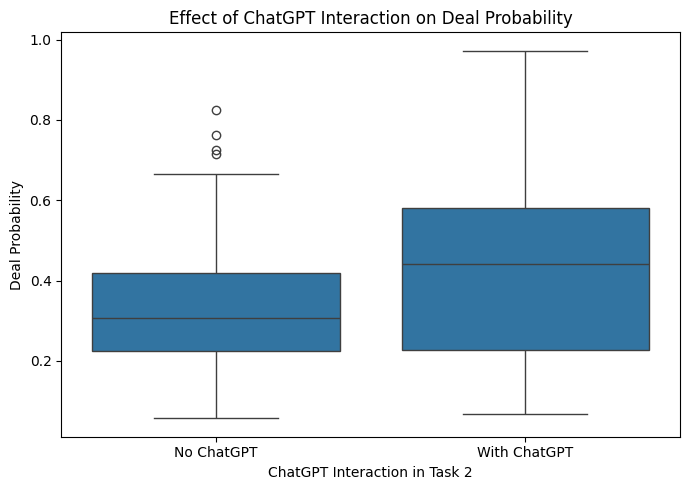

In [76]:
# compute correlation of deal_probablity and chatgpt interaction in task 2
correlation = df_ideas["deal_probability"].corr(df_ideas["Task2_ChatGPT_Interaction"])
print(f"Correlation between ChatGPT access (Task 2) and idea diversity: {correlation:.3f}")

# build OLS model
X = df_ideas["Task2_ChatGPT_Interaction"] 
X = sm.add_constant(X)
y = df_ideas["deal_probability"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot to show differences in groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="deal_probability", data=df_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 2")
plt.ylabel("Deal Probability")
plt.title("Effect of ChatGPT Interaction on Deal Probability")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:       deal_probability   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.6182
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.761
Time:                        09:28:30   Log-Likelihood:                 18.235
No. Observations:                 100   AIC:                            -18.47
Df Residuals:                      91   BIC:                             4.977
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

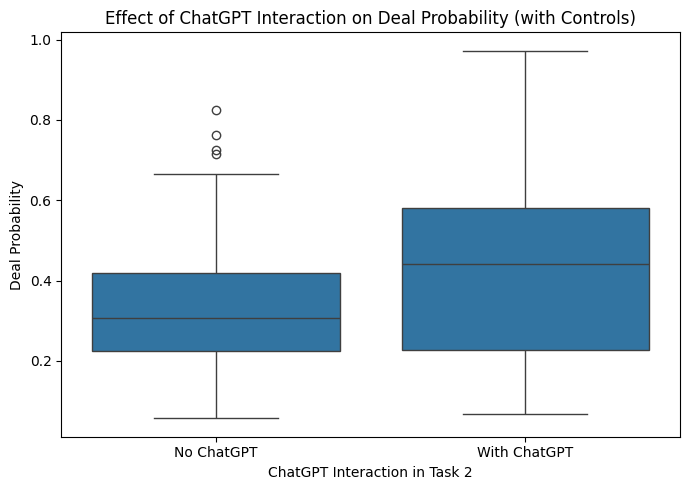

In [77]:
# Correlation of deal_probability + Task2_ChatGPT_Access + controls
# define predictors
predictors = [
    'Task2_ChatGPT_Access',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_ideas.dropna(subset=predictors + ["deal_probability"])

# build OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["deal_probability"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot to show differences between groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="deal_probability", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 2")
plt.ylabel("Deal Probability")
plt.title("Effect of ChatGPT Interaction on Deal Probability (with Controls)")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:       deal_probability   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.7432
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.653
Time:                        09:28:30   Log-Likelihood:                 18.753
No. Observations:                 100   AIC:                            -19.51
Df Residuals:                      91   BIC:                             3.940
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

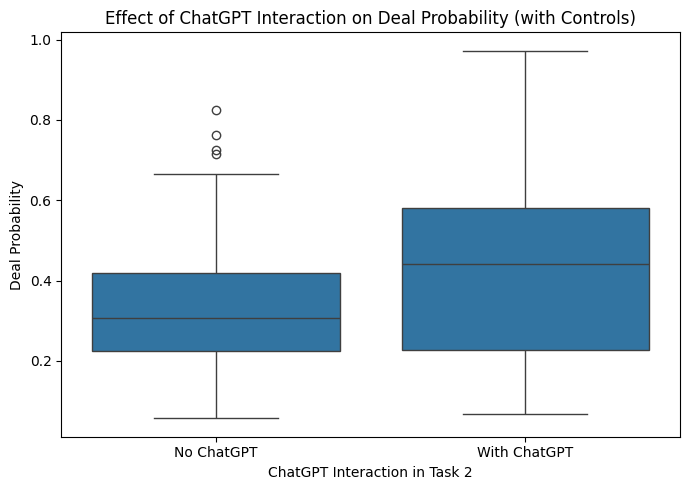

In [78]:
# Correlation of deal_probability + Task2_ChatGPT_Interaction + controls
# define predictors
predictors = [
    'Task2_ChatGPT_Interaction',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_ideas.dropna(subset=predictors + ["deal_probability"])

# build OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["deal_probability"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot to show differences between groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="deal_probability", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 2")
plt.ylabel("Deal Probability")
plt.title("Effect of ChatGPT Interaction on Deal Probability (with Controls)")
plt.tight_layout()
plt.show()


In [79]:
# define function to predict deal probability
def predict_row(row, model):
    embedding = get_openai_embeddings([row["Task2"]])[0].reshape(1, -1)
    prob = model.predict(embedding)[0][0]  
    prediction = int(prob > 0.5)
    return pd.Series({"deal_probability": prob, "deal_prediction": prediction})

# apply to participant-generated ideas
df_chatgpt[["deal_probability", "deal_prediction"]] = df_chatgpt.apply(
    lambda row: predict_row(row, model=model_xgb), axis=1
)

display(df_chatgpt.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

,Iteration,DAT,Task1,Task2,embedding,most_similar_sharktank_product_list,most_similar_sharktank_product,cosine_similarity,deal_probability,deal_prediction
0,1,"Elephant, cloud, guitar, lighthouse, cupcake, ...",Eco-Commuter App \nUrban Vertical Gardens \n...,"Sure, I'll refine the Eco-Commuter App. The co...","[0.021029021590948105, -0.0013314944226294756,...",832,"The Air Car, developed by Zero Pollution Motor...",0.469668,0.240156,0.0
1,2,"Whale, guitar, cactus, spoon, thunder, zebra, ...",Urban Vertical Farming Kits \nSolar-Powered C...,The Eco-Friendly Ride-Sharing App connects env...,"[-0.0015064658364281058, -0.05736448988318443,...",832,"The Air Car, developed by Zero Pollution Motor...",0.537363,0.367319,0.0
2,3,"Pillow, galaxy, violin, cactus, sandwich, bicy...",Smart Solar Windows \nCommunity Garden Networ...,Smart Solar Windows harness solar energy using...,"[-0.033985767513513565, 0.021731285378336906, ...",355,Grouphug’s window solar charger is a 10-watt p...,0.474044,0.713956,1.0
3,4,"Sandwich, galaxy, pencil, whisper, fog, dragon...",EcoSmart Home Hubs \nUrban Vertical Gardens ...,EcoSmart Home Hubs offer an all-in-one solutio...,"[0.012508130632340908, -0.02712314948439598, -...",795,"The Keen Vent, a groundbreaking product from K...",0.415268,0.424891,0.0
4,5,"Spoon, lamp, galaxy, sandcastle, butterfly, um...",Urban Vertical Gardens \nEco-Friendly Commut...,"The ""AI-Driven Energy Optimizers"" concept focu...","[-0.004390164744108915, -0.00809512473642826, ...",324,"ABii, the smart robot tutor, engages students ...",0.415354,0.358207,0.0


In [96]:
df_chatgpt_2 = df_chatgpt[['Task2', 'deal_probability']]
df_chatgpt_2['GroupAssignment'] = "AI_AI"
df_ideas_2 = df_ideas[['idea_elaboration', 'deal_probability', 'GroupAssignment']]

df_summary = pd.concat([df_ideas_2, df_chatgpt_2], ignore_index=True)
df_summary['IdeaSource'] = df_summary['GroupAssignment'].apply (lambda x: "Human" if x in ['Human_Human', 'Human/AI_Human'] else "AI" if  x in ['AI_AI'] else "Human/AI" )
display(df_summary.head())

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_21220/1816436029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chatgpt_2['GroupAssignment'] = "AI_AI"


,idea_elaboration,deal_probability,GroupAssignment,Task2,IdeaSource
0,A Smart outlet helps save electricity by autom...,0.725807,Human_Human,NaN,Human
1,Shoes made of ocean plastic would reduce the w...,0.227760,Human/AI_Human,NaN,Human
2,Reusable water bottles can be a key component ...,0.745676,Human/AI_Human/AI,NaN,Human/AI
3,Core Concept: reuseable bags to minimize envir...,0.279115,Human_Human/AI,NaN,Human/AI
4,Community Solar sharing is a decentralized ene...,0.419057,Human/AI_Human,NaN,Human


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_21220/3679479838.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


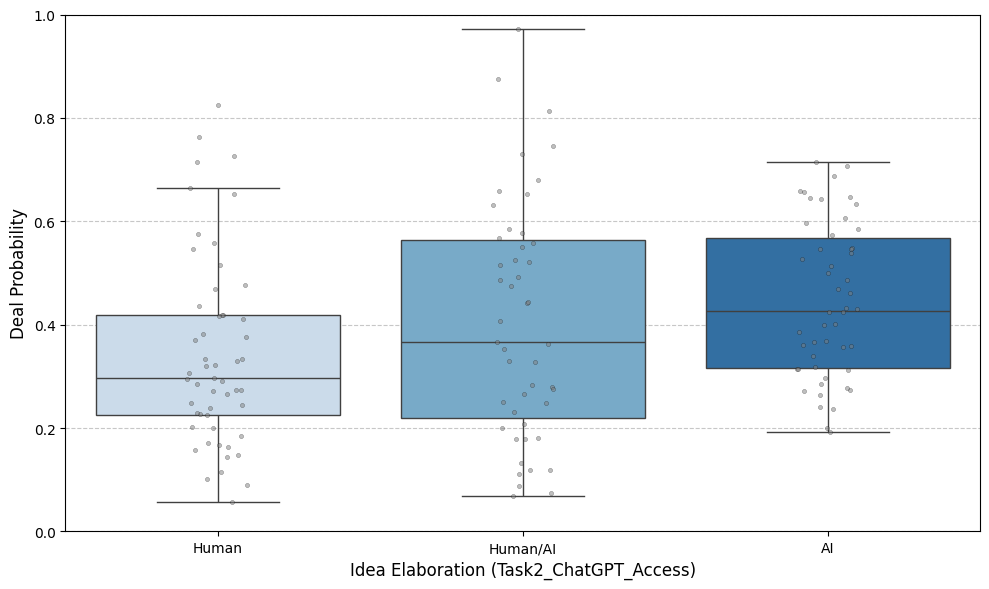

In [101]:
# Define general plot set-up
plt.figure(figsize=(10, 6))
group_order = ["Human", "Human/AI", "AI"] 

# Boxplot for average and SD
sns.boxplot(
    x="IdeaSource",
    y="deal_probability",
    data=df_summary,
    order=group_order,
    palette="Blues",
    showfliers=False
)

# Stripplot for each data point
sns.stripplot(
    x="IdeaSource",
    y="deal_probability",
    data=df_summary,
    order=group_order,
    jitter=True,
    dodge=True,
    size=3,
    alpha=0.5,
    color='gray',
    edgecolor='black',    
    linewidth=0.3,       
)

# Plot details
plt.xticks(ha='center')
plt.xlabel("Idea Elaboration (Task2_ChatGPT_Access)", fontsize=12)
plt.ylabel("Deal Probability", fontsize=12)
#plt.title("Impact of ChatGPT Interaction on Deal Probability (Task 2)", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_21220/1786234857.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


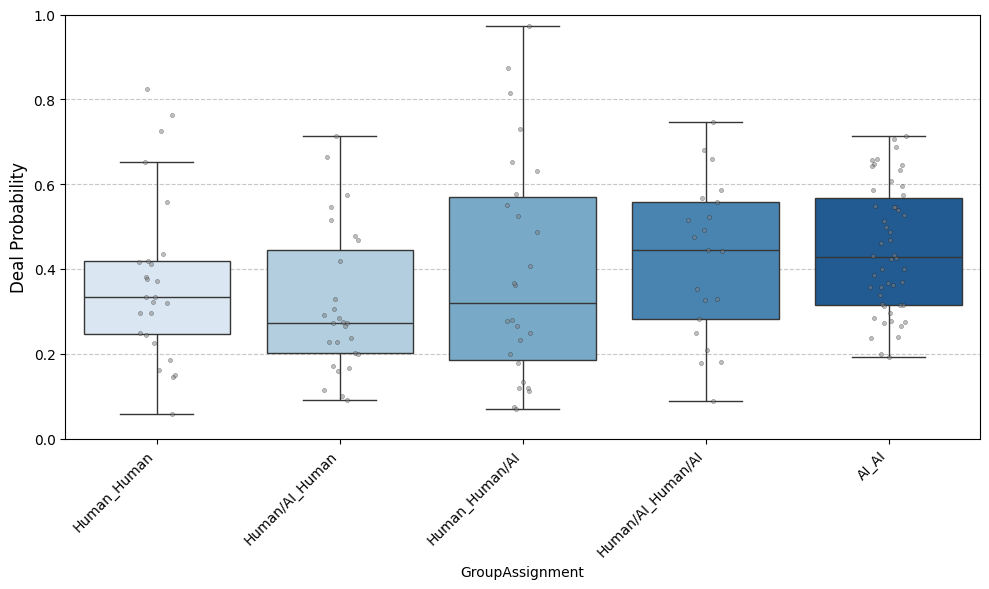

In [ ]:
# Define general plot set-up
plt.figure(figsize=(10, 6))
group_order = ["Human_Human", "Human/AI_Human", "Human_Human/AI", "Human/AI_Human/AI", "AI_AI"] 

# Boxplot for average and SD
sns.boxplot(
    x="GroupAssignment",
    y="deal_probability",
    data=df_summary,
    order=group_order,
    palette="Blues",
    showfliers=False
)

# Stripplot for each data point
sns.stripplot(
    x="GroupAssignment",
    y="deal_probability",
    data=df_summary,
    order=group_order,
    jitter=True,
    dodge=True,
    size=3,
    alpha=0.5,
    color='gray',
    edgecolor='black',    
    linewidth=0.3,       
)

# Plot details
plt.xticks(rotation=45, ha='right')
plt.xlabel("Experimental Group", fontsize=12)
plt.ylabel("Deal Probability", fontsize=12)
#plt.title("Impact of ChatGPT Interaction on Deal Probability (Task 2)", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [103]:
print(df_summary.groupby('IdeaSource')['deal_probability'].mean())

IdeaSource
AI          0.446676
Human       0.343901
Human/AI    0.407255
Name: deal_probability, dtype: float64
